In [1]:
import cv2 
from matplotlib import pyplot as plt

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
import os
import csv
import cv2
from frame import FLCDataset, visualize_transformed_image


In [3]:
train_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_train.csv", r"C:\Users\lucyc\Desktop\face_loc_d")
val_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_val.csv", r"C:\Users\lucyc\Desktop\face_loc_d")
test_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_test.csv", r"C:\Users\lucyc\Desktop\face_loc_d")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

In [4]:
a, b, c = next(iter(val_loader))

In [5]:
a.shape

torch.Size([128, 3, 24, 24])

In [6]:
def get_args(b):
    return [int(float(x)//1) for x in b.split()]

In [7]:
#visualize_transformed_image(a[6],get_args(b[6]),get_args(b[6]))

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
torch.cuda.empty_cache()

cuda:0


In [9]:
class PNet(nn.Module):

    def __init__(self):
        super(PNet, self).__init__()

        # 定义网络层
        self.conv1 = nn.Conv2d(3, 10, 3)  #12 -> 10 -> maxp -> 5
        self.conv2 = nn.Conv2d(10, 16, 3) #5 -> 3
        self.conv3 = nn.Conv2d(16, 32, 3) #3 -> 1

        self.face_det = nn.Conv2d(32, 2, 1) #1 -> 1
        self.bbox = nn.Conv2d(32, 4, 1) #1 -> 1
        self.landmark = nn.Conv2d(32, 10, 1) #1 -> 1

    def forward(self, x):
        # 定义前向传播
        x = F.relu(self.conv1(x)) #10
        x = F.max_pool2d(x, 2) #5
        x = F.relu(self.conv2(x)) #3
        x = F.relu(self.conv3(x)) #1

        facedet = self.face_det(x)
        bbox = self.bbox(x)
        landmark = self.landmark(x)

        facedet = torch.flatten(facedet, 1)
        bbox = torch.flatten(bbox, 1)
        landmark = torch.flatten(landmark, 1)

        return facedet, bbox, landmark


In [10]:
class RNet(nn.Module):

    def __init__(self):
        super(RNet, self).__init__()

        # 定义网络层
        self.conv1 = nn.Conv2d(3, 28, 3)  #24 -> 22 -> maxp -> 11
        self.conv2 = nn.Conv2d(28, 48, 3) #11 -> 9 -> maxp -> 4
        self.conv3 = nn.Conv2d(48, 64, 2) #4 -> 3

        self.linear1 = nn.Linear(64*3*3, 128)

        self.face_det = nn.Linear(128, 2)
        self.bbox = nn.Linear(128, 4)
        self.landmark = nn.Linear(128, 10)

    def forward(self, x):
        # 定义前向传播
        x = F.relu(self.conv1(x)) #22
        x = F.max_pool2d(x, 2) #11
        x = F.relu(self.conv2(x)) #9
        x = F.max_pool2d(x, 2) #4
        x = F.relu(self.conv3(x)) #3

        x = x.view(-1, 64*3*3)
        x = F.relu(self.linear1(x))

        facedet = self.face_det(x)
        bbox = self.bbox(x)
        landmark = self.landmark(x)

        return facedet, bbox, landmark


In [11]:
losscrs = torch.nn.CrossEntropyLoss()
class RNetLoss(nn.Module):
    def __init__(self):
        super(RNetLoss, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype in ["2", "3", "4"]:
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([1], device=device))

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([0], device=device))

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0.5 * bbox_loss + facedet_loss)

            elif ltype == "5":
                # 对于类型3，计算关键点损失
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([0], device=device))

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (1 * landmark_loss + facedet_loss)

        loss_total = loss_total / len(ltypes)
        #loss_total = loss_total
        return loss_total

In [12]:
losscrs = torch.nn.CrossEntropyLoss()
class PNetLoss(nn.Module):
    def __init__(self):
        super(PNetLoss, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype in ["2", "3", "4"]:
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([1], device=device))

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([0], device=device))

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0.5 * bbox_loss + facedet_loss)

            elif ltype == "5":
                # 对于类型3，计算关键点损失
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([0], device=device))

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (1 * landmark_loss + facedet_loss)

        loss_total = loss_total / len(ltypes)
        #loss_total = loss_total
        return loss_total

In [13]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (face_det): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (bbox): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (landmark): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)


In [ ]:
training_loss = []
validation_loss = []

for i in range(20):
    model.train()  # 设置模型为训练模式

    train_x = []
    train_loss_y = []

    train_loss_acc = 0.
    train_num = 0

    for inputs in train_loader:
        
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        optimizer.zero_grad()  # 清除之前的梯度
        loss = criterion(facedet, bbox, landmark, label, ltypes)
        # 反向传播和优化
        loss.backward()  # 反向传播计算当前的梯度
        optimizer.step()  # 更新参数

        train_loss_acc += loss.item()
        train_num += 1

        train_x.append(train_num)
        train_loss_y.append(loss.item())
        
        print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*128, len(train_dataset), i)
    
    training_loss.append((train_x, train_loss_y))

    model.eval()  # 设置模型为评估/测试模式

    val_loss_acc = 0
    val_num = 0
    with torch.no_grad():
        for inputs in val_loader:
            img_tensor = inputs[0].to(device)
            label = inputs[1].to(device)
            ltypes = inputs[2]

            facedet, bbox, landmark = model(img_tensor)
            loss = criterion(facedet, bbox, landmark, label, ltypes)

            val_loss_acc += loss.item()
            val_num += 1

            print(val_num,loss.item(),val_loss_acc/val_num, val_num*128, len(val_dataset))
    
    validation_loss.append(val_loss_acc/val_num)
        

        
    

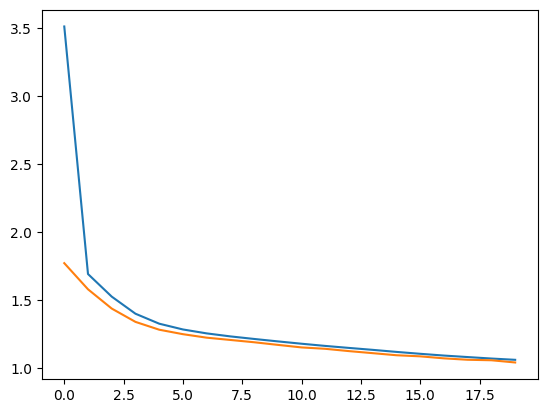

In [21]:
validation_loss
train_loss = [sum(x[1])/len(x[1]) for x in training_loss]
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()


In [13]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = RNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = RNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


RNet(
  (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 64, kernel_size=(2, 2), stride=(1, 1))
  (linear1): Linear(in_features=576, out_features=128, bias=True)
  (face_det): Linear(in_features=128, out_features=2, bias=True)
  (bbox): Linear(in_features=128, out_features=4, bias=True)
  (landmark): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
training_loss = []
validation_loss = []


In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [30]:

for i in range(43,50):
    model.train()  # 设置模型为训练模式

    train_x = []
    train_loss_y = []

    train_loss_acc = 0.
    train_num = 0

    for inputs in train_loader:
        
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        optimizer.zero_grad()  # 清除之前的梯度
        loss = criterion(facedet, bbox, landmark, label, ltypes)
        # 反向传播和优化
        loss.backward()  # 反向传播计算当前的梯度
        optimizer.step()  # 更新参数

        train_loss_acc += loss.item()
        train_num += 1

        train_x.append(train_num)
        train_loss_y.append(loss.item())
        
        print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*128, len(train_dataset), i)
    
    training_loss.append((train_x, train_loss_y))

    model.eval()  # 设置模型为评估/测试模式

    val_loss_acc = 0
    val_num = 0
    with torch.no_grad():
        for inputs in val_loader:
            img_tensor = inputs[0].to(device)
            label = inputs[1].to(device)
            ltypes = inputs[2]

            facedet, bbox, landmark = model(img_tensor)
            loss = criterion(facedet, bbox, landmark, label, ltypes)

            val_loss_acc += loss.item()
            val_num += 1


            print(val_num,loss.item(),val_loss_acc/val_num, val_num*128, len(val_dataset))
    
    validation_loss.append(val_loss_acc/val_num)
        
    

1 0.7582634091377258 0.0037913170456886293 128 178783 43
2 0.6041386127471924 0.006812010109424591 256 178783 43
3 0.4911031126976013 0.009267525672912598 384 178783 43
4 0.7534670233726501 0.013034860789775848 512 178783 43
5 0.4354896545410156 0.015212309062480927 640 178783 43
6 0.5555962920188904 0.017990290522575378 768 178783 43
7 0.6388285756111145 0.02118443340063095 896 178783 43
8 0.5447911024093628 0.023908388912677766 1024 178783 43
9 0.45239484310150146 0.026170363128185273 1152 178783 43
10 0.5765197277069092 0.029052961766719818 1280 178783 43
11 0.7147147059440613 0.03262653529644013 1408 178783 43
12 0.5868123173713684 0.03556059688329696 1536 178783 43
13 0.6608119010925293 0.03886465638875961 1664 178783 43
14 0.6890230774879456 0.042309771776199344 1792 178783 43
15 0.5357678532600403 0.04498861104249954 1920 178783 43
16 0.6734484434127808 0.048355853259563444 2048 178783 43
17 0.6177765727043152 0.05144473612308502 2176 178783 43
18 0.7007189989089966 0.0549483311

In [33]:
validation_loss


[4.050860360137418,
 3.5746487287374644,
 3.3720585117992172,
 3.2575900758433547,
 3.0280797552858663,
 2.91704329669985,
 2.8380267701597295,
 2.764104073883122,
 2.6888337186259084,
 2.6356750971231704,
 2.5579218426321306,
 2.5230785995467095,
 2.444928265025473,
 2.413233703018254,
 2.342947812161894,
 2.3544662039504094,
 2.286712313309694,
 2.267462322854588,
 2.291812316984193,
 2.194717932970096,
 2.210097803009881,
 2.152787403163747,
 2.14322038491567,
 2.1302076761539164,
 2.118999493427766,
 2.0885858428783908,
 2.104690125864795,
 2.057516959997324,
 2.024771382666042,
 2.0352977269735093,
 1.9985888585066185,
 2.0255481514156375,
 2.004771602459443,
 1.9853545091091058,
 1.9702492035352266,
 1.9686239443273625,
 1.9330169777584891,
 1.9199514862818596,
 1.9295392831166585,
 1.9241152798008716,
 1.903518772023356,
 0.664345184707234,
 0.6345759839074224,
 18.767987104562614,
 1.9045411037583637,
 1.9312876029911203,
 1.8179379553876371,
 1.8086681136718163,
 1.76603359391

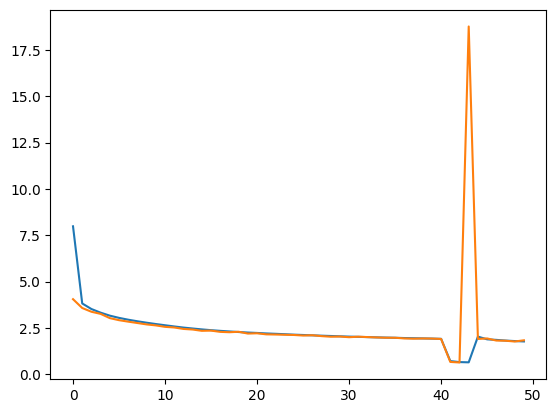

In [32]:
validation_loss
train_loss = [sum(x[1])/len(x[1]) for x in training_loss]
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()


In [ ]:
# 验证多任务训练在 单一任务上的表现 是否有提升
# 人脸平均绝对值误差 单任务        全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.135152058410645
# 人脸平均绝对值误差 均方差 多任务 全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.84007318687439
# 人脸交叉熵损失  单任务          全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 11.208772300338746
# 人脸交叉熵损失 均方差  多任务   全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 13.04701942062378

In [17]:

criterion = RNetLoss()

model.eval() 
val_loss_acc = 0
val_num = 0
with torch.no_grad():
    for inputs in val_loader:
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        loss = criterion(facedet, bbox, landmark, label, ltypes)

        val_loss_acc += loss.item()
        val_num += 1

        print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(val_dataset))

print("val loss avg:", val_loss_acc/val_num)


1 2.4574203491210938 2.4574203491210938 32 14898
2 3.728027582168579 3.0927239656448364 64 14898
3 2.540447235107422 2.9086317221323648 96 14898
4 4.25405216217041 3.244986832141876 128 14898
5 2.640634775161743 3.1241164207458496 160 14898
6 3.4796533584594727 3.1833725770314536 192 14898
7 3.8111813068389893 3.27305953843253 224 14898
8 2.943222761154175 3.2318299412727356 256 14898
9 2.8454060554504395 3.188893953959147 288 14898
10 4.184516429901123 3.2884562015533447 320 14898
11 2.820634603500366 3.2459269653667104 352 14898
12 3.61151385307312 3.2763925393422446 384 14898
13 2.7772486209869385 3.2379968533149133 416 14898
14 3.4744904041290283 3.2548892498016357 448 14898
15 2.5700762271881104 3.2092350482940675 480 14898
16 1.8705722093582153 3.1255686208605766 512 14898
17 3.4135985374450684 3.1425115571302524 544 14898
18 4.062824726104736 3.193640066517724 576 14898
19 2.4672329425811768 3.155408112626327 608 14898
20 3.650832414627075 3.180179327726364 640 14898
21 3.298667

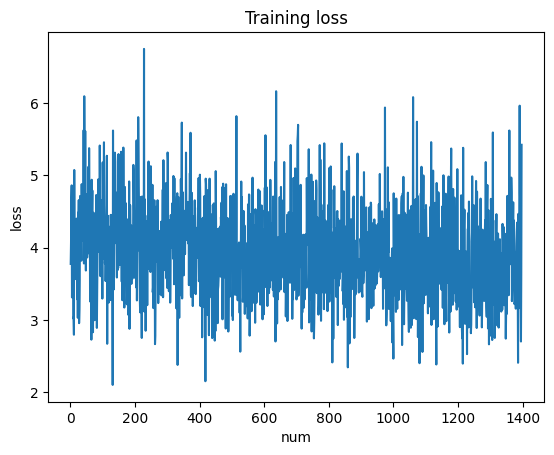

In [18]:
# draw loss curve
plt.plot(training_loss[1][0], training_loss[1][1], label='train')
plt.xlabel('num')
plt.ylabel('loss')
plt.title('Training loss')
plt.show()



In [28]:
# 保存模型
torch.save(model, 'face_loc_r_42.pth')

In [22]:
# load model
model_trained = torch.load('face_loc_p.pth')
model_trained.eval()  # 设置模型为评估/测试模式


PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (face_det): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (bbox): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (landmark): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)

In [23]:
aa = iter(test_loader)

In [24]:

a, b, c = next(aa)

In [25]:
def get_argsn(b):
    return [int(float(x)//1) for x in b]

def is_face(i):
    if i == "0":
        return "face"
    if i == "1":
        return "face"
    if i == "2":
        return "not face"
    if i == "3":
        return "not face"
    if i == "4":
        return "not face"
    if i == "5":
        return "face"

In [35]:
right = 0
total = 0
for i in range(128):

    #visualize_transformed_image(a[i],get_argsn(b[i]),get_argsn(b[i]))
    #print(is_face(c[i]))

    with torch.no_grad():
        face_det, bbox, landmark = model_trained(a[i].to(device))
    probabilities = torch.nn.functional.softmax(face_det, dim=0)
    # print(bbox)
    # print(landmark)

    # if probabilities[0][0] > probabilities[0][1]:
    #     print("face")
    #     visualize_transformed_image(a[i],get_argsn(bbox[0]),get_argsn(landmark[0]))   
    # else:
    #     print("not face")
    #     visualize_transformed_image(a[i],[0,0,0,0],None)
    if probabilities[0] > probabilities[1] and is_face(c[i]) == "face":
        right += 1
    if probabilities[0] < probabilities[1] and is_face(c[i]) == "not face":
        right += 1

    total += 1

print("total: {}".format(total))
print("right: {}".format(right))
print("accuracy: {}".format(right/128))

total: 128
right: 103
accuracy: 0.8046875


In [68]:
def get_argsn(b):
    return [int(float(x)//1) for x in b]

def is_face(i):
    if i == "0":
        return "face"
    if i == "1":
        return "face"
    if i == "2":
        return "not face"
    if i == "3":
        return "not face"
    if i == "4":
        return "not face"
    if i == "5":
        return "face"
    
# load model
model_trained = torch.load('face_loc_r_1_NN.pth')
model_trained.eval()  # 设置模型为评估/测试模式
test_dataset = iter(test_loader)

right = 0
total = 0
for a,b,c in test_dataset:
    try:
        for i in range(128):

            with torch.no_grad():
                face_det, bbox, landmark = model_trained(a[i].to(device))
            probabilities = F.softmax(face_det, dim=1)

            if probabilities[0][0] > probabilities[0][1] and is_face(c[i]) == "face":
                right += 1
            if probabilities[0][0] < probabilities[0][1] and is_face(c[i]) == "not face":
                right += 1

            total += 1
    except:
        pass

print("total: {}".format(total))
print("right: {}".format(right))
print("accuracy: {}".format(right/total))

total: 90362
right: 74018
accuracy: 0.819127509351276
